# Solve Viscous Burger's equation with periodic boundary conditions 

In [35]:
import torch 
# torch.set_default_dtype(torch.float32)
from torch import nn 
from muon import Muon
from collections import OrderedDict # To place the hidden layers orderly 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import scipy.io # Provide tools for input and output data 
from scipy.interpolate import griddata # Used to interpolate values on a regular grid from scattered data points.
import warnings

warnings.filterwarnings('ignore') # Import the built-in Python warnings module, and tell Python to ignore all warning messages.”
import time 

np.random.seed(1234) 


In [36]:
# MPS or CUDA or CPU 
if torch.backends.mps.is_available(): 
    device = torch.device('mps') 
elif torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 
# 
print(f"Working on {device}") 

Working on mps


# Self-Adaptive Physics-informed Neural Network 

In [37]:
class AdaptiveLoss(nn.Module): 
    def __init__(self, layers, N_r, N_b, N_0): 
        super(AdaptiveLoss, self).__init__()

        # Layers 
        self.depth = len(layers) - 1 # total layers, including the input and out put layers 

        # Self Adaptive parameters 
        # The parameters will be included in adaptive_loss.parameters() 
        self.lambda_r = nn.Parameter(torch.rand(N_r, 1), requires_grad = True) 
        # self.lambda_r = nn.Parameter(10 * torch.ones(N_r, 1), requires_grad = True) 
        self.lambda_b = nn.Parameter(torch.rand(N_b, 1), requires_grad = True) 
        self.lambda_0 = nn.Parameter(torch.rand(N_0, 1), requires_grad = True) 
        

        # Set up layer order dict 
        self.activation = nn.Tanh() 

        layer_list = list() 
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, nn.Linear(layers[i], layers[i+1])) 
            ) 
            layer_list.append(('activation_%d' % i, self.activation)) 

        layer_list.append( 
            ('layer_%d' % (self.depth - 1), nn.Linear(layers[-2], layers[-1])) 
        ) 
        layerDict = OrderedDict(layer_list) 

        # deploy layers 
        self.layers = nn.Sequential(layerDict) 

    def forward(self, x): 
        out = self.layers(x) 
        return out 

In [38]:
# the physics-informed neural network 
class PINN():  
    # For periodic boundary conditions 
    def __init__(self, X, X_init, u_init, t_bc, layers, lb, ub, nu, N_r = 10000, N_b = 100, N_0 = 100):  
        # X: training points; X_init, u_init: initial training data 
        # lb, ub: lower and upper bound of the data X as boundary; nu: viscosity coefficients 
        # boundary conditions: domain bounds 
        self.lb = torch.tensor(lb).float().to(device) 
        self.ub = torch.tensor(ub).float().to(device) 

        # Initial setup    
        self.length_x = ub[0].item() - lb[0].item() # length of the space domain 
        self.length_t = ub[1].item() - lb[1].item() # length of the time span 
        self.N_r = N_r
        self.N_0 = N_0 
        self.N_b = N_b
        
        self.X_tra = torch.tensor(X[:, 0:1], requires_grad = True).float().to(device) # spatial points 
        self.T_tra = torch.tensor(X[:, 1:2], requires_grad = True).float().to(device) # temporal points 

        # Initial data 
        self.x_init = torch.tensor(X_init[:]).float().to(device) # initial data points 
        self.t_init = torch.zeros_like(self.x_init).float().to(device) # t = 0 
        self.u_init = torch.tensor(u_init).float().to(device)

        # Boundary data points for periodic boundary conditions 
        self.t_bc = torch.tensor(t_bc).float().to(device) 
        
        # For periodic boundary condition
        self.x_left = self.lb[0] * torch.ones_like(self.t_bc) 
        self.x_right = self.ub[0] * torch.ones_like(self.t_bc) 
               
        # Viscosity coefficient and the coefficient for the nonlinear term  
        self.nu = nu

        # deep neural network 
        self.dnn = AdaptiveLoss(layers, N_r, N_b, N_0).to(device) 
        
        # optimizers: using the same settings 
        self.optimizer = torch.optim.LBFGS( # requires multiple evaluation of the loss function per iteration 
            self.dnn.layers.parameters(),    # target to be optimized 
            lr = 1.0,    # learning rate: step length 
            max_iter = 20,    # maximum number of iterations 
            max_eval = 500000,    # total number of times the closure (loss + backward pass) can be called 
            history_size = 50, 
            tolerance_grad = 0.0, 
            tolerance_change = 0.0,
            line_search_fn = "strong_wolfe"      # "strong wolfe condition
        ) 
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.layers.parameters(), lr = 1e-3, betas = (0.9, 0.999))
        self.optimizer_Adam_r = torch.optim.Adam([self.dnn.lambda_r], lr = 1e-3, betas = (0.9, 0.999)) # Optimizers always take lists / iterables, never single tensors directly
        self.optimizer_Adam_0 = torch.optim.Adam([self.dnn.lambda_0], lr = 1e-3, betas = (0.9, 0.999)) 
        self.optimizer_Adam_b = torch.optim.Adam([self.dnn.lambda_b], lr = 1e-3, betas = (0.9, 0.999)) 

        self.iter = 0 
        
    def sample_points(self, N_pts): 
        # Generate interior points on an interval (lb, ub)

        # We first try randomly pick the spatial and temporal points; We may try randomly in x and uniform in time for the next step 
        x_int_train = self.length_x * torch.rand(N_pts, 1, device = device) + self.lb[0] # affine transformation of x-axis 
        t_int_train = self.length_t * torch.rand(N_pts, 1, device = device) + self.lb[1] # affine transformation of t-axis 
        
        return x_int_train, t_int_train  

    def init_points(self, N_init): 
        x_init = self.length_x * torch.rand(N_init, 1, device = device, requires_grad = False) + lb[0] # affine transformation of x-axis 

        return x_init 
     
    def bc_points(self, N_bc):  
    
        t_bc = self.length_t * torch.rand(N_bc, 1, device = device, requires_grad = False) + lb[1]  
        x_bc = self.length_x * torch.rand(N_bc, 1, device = device, requires_grad = False) + lb[0] 
        return x_bc, t_bc 
        
    def u_0(self, x): 
        u =  - torch.sin(torch.pi * x)  
        return u 
    
    def net_u(self, x, t): # predicted value 
        u = self.dnn(torch.cat([x, t], dim = 1)) 
        return u 

    def net_f(self, x ,t): 
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x,t) 

        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs = torch.ones_like(u), 
            retain_graph = True, 
            create_graph = True
        )[0]

        u_x = torch.autograd.grad( 
            u, x, 
            grad_outputs = torch.ones_like(u), 
            retain_graph = True, 
            create_graph = True
        )[0] 

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs = torch.ones_like(u), 
            retain_graph = True, 
            create_graph = True 
        )[0] 
        
        f = u_t + u * u_x - self.nu * u_xx 
        return f 

    def loss_func(self, x_init, t_init, u_init, x_left, x_right, t_bd, x_int, t_int, lambda_r, lambda_0, lambda_b = 1): 

        f_pred = self.net_f(x_int, t_int) 
        u0_pred = self.net_u(x_init, t_init) 
        u_left_pred = self.net_u(x_left, t_bd) 
        u_right_pred = self.net_u(x_right, t_bd) 

        mse_0_u = torch.pow((u_init - u0_pred), 2) 
        
        mse_r_u = torch.pow(f_pred, 2) 

        mse_b_u = torch.pow(u_left_pred - 0, 2) + torch.pow(u_right_pred - 0, 2) + torch.pow(u_left_pred - u_right_pred, 2) 
         
        return (
            torch.mean(torch.pow(lambda_0.detach(), 2) * mse_0_u) + torch.mean(torch.pow(lambda_b.detach(), 2) * mse_b_u)
            + torch.mean(torch.pow(lambda_r.detach(), 2) * mse_r_u),
            torch.mean(torch.pow(lambda_0, 2) * mse_0_u.detach()),
            torch.mean(torch.pow(lambda_r, 2) * mse_r_u.detach()),
            torch.mean(torch.pow(lambda_b, 2) * mse_b_u.detach())
        )
       
   
    def closure(self): 
        loss_value, mse_0, mse_r, mse_b = self.loss_func(self.x_init, self.t_init, self.u_init, self.x_left, self.x_right, self.t_bc, self.X_tra, self.T_tra, self.dnn.lambda_r, self.dnn.lambda_0, self.dnn.lambda_b) 
        self.optimizer.zero_grad()                             # reset gradients
        loss_value.backward()                                  # compute gradients but only the network weights will be updated 
        self.iter += 1
        if self.iter % 100 == 0:
            print('It: %d, Loss: %e' % (self.iter, loss_value.item()))
        return loss_value  
    
    def train(self, Iter): # change the input and other parameters! 
        self.dnn.train()
        # Backward and optimize: 2nd phase optimization 
        # Two Phase optimization
        
        for epoch in range(Iter):            
            loss_value, mse_0, mse_r, mse_b = self.loss_func(self.x_init, self.t_init, self.u_init, self.x_left, self.x_right, self.t_bc, self.X_tra, self.T_tra, self.dnn.lambda_r, self.dnn.lambda_0, self.dnn.lambda_b)  

            # Network parameter update 
            self.optimizer_Adam.zero_grad()
            
            # self.optimizer_Muon.zero_grad()
            loss_value.backward()
            self.optimizer_Adam.step() # only sees the gradient of the network weights 

            self.optimizer_Adam_r.zero_grad() 
            self.optimizer_Adam_0.zero_grad() 
            self.optimizer_Adam_b.zero_grad() 

            (- mse_0).backward() 
            (- mse_r).backward()
            (- mse_b).backward()
            
            self.optimizer_Adam_0.step() # only sees the gradient of lambda_r  
            self.optimizer_Adam_r.step() # only sees the gradient of lambda_0 
            self.optimizer_Adam_b.step() # only sees the gradient of lambda_b 
            # self.optimizer_Muon.step() 
            
            if epoch % 100 == 0: 
                print(
                    'It: %d, Loss: %.3e' % 
                    ( 
                        epoch, 
                        loss_value.item()
                    )
                )

        for i in range(1200):  # 2500 × 20 ≈ 50,000 iterations
            self.optimizer.step(self.closure) # Never pass tensors into optimizer.step()

    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad = True).float().to(device) 
        t = torch.tensor(X[:, 1:2], requires_grad = True).float().to(device) 
        
        self.dnn.eval()

        u = self.net_u(x, t) 
        f = self.net_f(x, t) 
        
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy() 

        return u, f 

# Configurations 

In [39]:
# Domain bounds 
lb = torch.tensor([-1.0, 0.0]) # second element for time 
ub = torch.tensor([1.0, 1.0]) # second element for time 
length_x = ub[0].item() - lb[0].item() # length of the space domain 
length_t = ub[1].item() - lb[1].item() # length of the time span 
nu = 0.01 / np.pi # viscosity constant 

layers = [2, 40, 40, 40, 40, 1] 

def sample_points(N_pts): 
    # Generate interior and boundary points on an interval (lb, ub) 

    # We first try randomly pick the spatial and temporal points; We may try randomly in x and uniform in time for the next step 
    x_int_train = length_x * np.random.rand(N_pts, 1) + lb[0].item() # affine transformation of x-axis 
    t_int_train = length_t * np.random.rand(N_pts, 1) + lb[1].item() # affine transformation of t-axis 

    return x_int_train, t_int_train 

def init_points(N_init): 
    x_init = length_x * np.random.rand(N_init, 1) + lb[0].item() # affine transformation of x-axis 

    return x_init 

def bc_points(N_bc): 
    t_bc = length_t * np.random.rand(N_bc, 1) + lb[1].item()  
    return t_bc 
    

# Generate Reference Solution

In [ ]:
# Define the initial condition
def u_0(x): 
    return - np.sin(np.pi * x) 
#load data, from Raissi et. al
data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['usol']
Exact_u = np.real(Exact)

# Generate test data 
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
print(f"X_star shape {np.shape(X_star)}") 

In [40]:
# Reference solutions can be generated using spectral methods or existing datasets.""" 
""" 
from scipy.fft import fft, ifft, fftfreq
# Define the True solution 
T = 1.0 
dt = 1e-4 
Time = np.arange(0, T + dt, dt) 
dt_inv = 1 / dt 
M = int(T / dt) + 1 
N = 10000; x = np.linspace(-1, 1, N, endpoint = False) 
L = 2.0 
dx = L / N 
k = fftfreq(N, d = dx); 
ik = 1j * np.pi * k # First order Fourier spectral derivative coefficients; scaling to match the domain [-1,1] 
ik_square = - np.pi ** 2 * k ** 2 # Second order Fourier spectral derivative coefficients 


u_true = np.zeros((M, N)) 
u_true[0, :] = u_0(x)
for i in range(M-1): 
    
    u_hat = fft(u_true[i, :])  
    du_square_hat = ik * fft(0.5 * np.power(u_true[i,:], 2))
    u_hat_next_step = (dt_inv * u_hat - du_square_hat ) / (dt_inv + nu * np.power(k, 2))
    u_true[i+1,:] = np.real(ifft(u_hat_next_step))

print(f"u_true shape: {np.shape(u_true)}")
print(f"x shape: {np.shape(x)}")
print(f"Time shape: {np.shape(Time)}") 
""" 


X_star shape (25600, 2)


# Grid points setup 

In [47]:
N_int = 200 
N_bd = 100 
N_init = 100 
N_train = 10000  
N_test = 1000  

# Generating collation points 
x_c, t_c = sample_points(N_int)
X_c, T_c = np.meshgrid(x_c,t_c) 

X_int = np.concatenate([X_c.flatten()[:,None], T_c.flatten()[:,None]], axis = 1) 
print(f"X_int shape: {np.shape(X_int)}") 


# Generating initial data 
X_init = init_points(N_init) 
U_init = u_0(X_init) 
print(f"X_init shape: {np.shape(X_init)}") 
print(f"U_init shape: {np.shape(U_init)}") 

# Generating boundary data 
T_bc = bc_points(N_bd) 

X_int shape: (40000, 2)
X_init shape: (100, 1)
U_init shape: (100, 1)


# Generating trainging and test data 

In [48]:
noise = 0.0 
# Create training data set 
idx_int = np.random.choice(X_int.shape[0], N_train, replace = False) 
print(np.shape(idx_int[:N_train]))  

# Training points 
X_u_train = X_int[idx_int, :] 
print(f"X_u_train shape: {np.shape(X_u_train)}") 

(10000,)
X_u_train shape: (10000, 2)


# Trainging 

In [49]:
# training 
start = time.time() 

model = PINN(X_u_train, X_init, U_init, T_bc, layers, lb, ub, nu) 
model.train(15000) 

end = time.time() 

It: 0, Loss: 1.665e-01
It: 100, Loss: 8.248e-02
It: 200, Loss: 8.106e-02
It: 300, Loss: 8.448e-02
It: 400, Loss: 8.987e-02
It: 500, Loss: 9.401e-02
It: 600, Loss: 1.004e-01
It: 700, Loss: 1.093e-01
It: 800, Loss: 1.217e-01
It: 900, Loss: 1.352e-01
It: 1000, Loss: 1.502e-01
It: 1100, Loss: 1.666e-01
It: 1200, Loss: 1.824e-01
It: 1300, Loss: 1.966e-01
It: 1400, Loss: 1.901e-01
It: 1500, Loss: 1.966e-01
It: 1600, Loss: 1.995e-01
It: 1700, Loss: 2.093e-01
It: 1800, Loss: 2.061e-01
It: 1900, Loss: 2.028e-01
It: 2000, Loss: 1.710e-01
It: 2100, Loss: 1.432e-01
It: 2200, Loss: 1.113e-01
It: 2300, Loss: 8.784e-02
It: 2400, Loss: 7.172e-02
It: 2500, Loss: 6.044e-02
It: 2600, Loss: 5.219e-02
It: 2700, Loss: 4.609e-02
It: 2800, Loss: 3.961e-02
It: 2900, Loss: 3.518e-02
It: 3000, Loss: 3.166e-02
It: 3100, Loss: 2.897e-02
It: 3200, Loss: 2.656e-02
It: 3300, Loss: 2.447e-02
It: 3400, Loss: 2.232e-02
It: 3500, Loss: 2.038e-02
It: 3600, Loss: 1.868e-02
It: 3700, Loss: 1.731e-02
It: 3800, Loss: 1.584e-0

# Test the accuracy 

In [51]:
# evaluations 
# u_pred, f_pred, u_bc_pred = model.predict(X_u_train, X_bc, T_bc)
u_pred, f_pred = model.predict(X_star) 
# u_pred, f_pred = model.predict(X_int)  
print(f"u_pred shape: {np.shape(u_pred)}") 
print(f"f_pred shape: {np.shape(f_pred)}")  
print(f"u_test shape: {np.shape(u_star)}") 

error_u = np.linalg.norm(abs(u_star - u_pred), 2) / np.linalg.norm(u_star, 2) # relative L^{2} square norm 
# error_u = np.linalg.norm((u_star - u_pred), ord = np.inf) / np.linalg.norm(u_star, ord = np.inf)
error_f = np.linalg.norm(abs(f_pred), ord = np.inf) 
# error_u_bc = np.linalg.norm(u_bc_pred - U_bc, 2) / np.linalg.norm(U_bc, 2) 


print('Error u: %e' % (error_u)) 
print('PDE loss: %e' % (error_f)) 
print(f'Training time is {end-start:.2f} seconds')



u_pred shape: (25600, 1)
f_pred shape: (25600, 1)
u_test shape: (25600, 1)
Error u: 1.237146e-02
PDE loss: 1.381857e+01
Training time is 567.83 seconds


In [52]:
U_pred = griddata(X_star, u_pred.flatten(), (X,T), method = 'cubic') 
F_pred = griddata(X_star, f_pred.flatten(), (X,T), method = 'cubic') 

Text(0.5, 1.0, '$t= 0.75$')

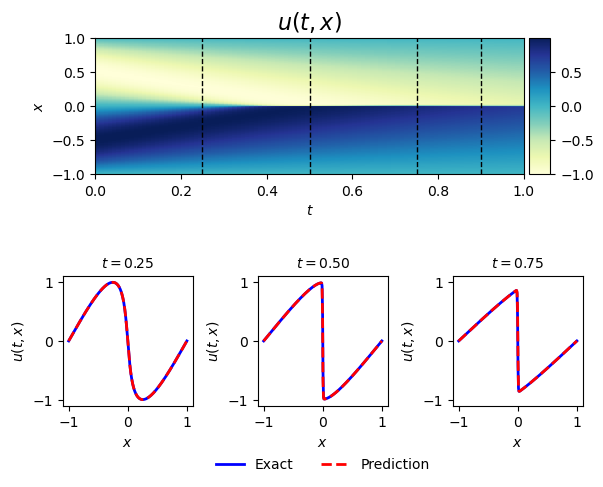

In [58]:
# Plotting script 

# Check!
X0 = np.concatenate((X_init, 0 * X_init), axis = 1) # (X0, 0)
X_lb = np.concatenate((0 * T_bc + lb[0].item(), T_bc), axis = 1) # (lb[0], T_bc) 
X_ub = np.concatenate((0 * T_bc + ub[0].item(), T_bc), axis = 1) 
X_u_train = np.vstack([X0, X_lb, X_ub])

fig, ax = plt.subplots(figsize = (6.5, 5.0)) 
ax.axis('off') 

####### Row 0: h(t,x) #################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top = 1-0.06, bottom = 1 - 1/3, left = 0.15, right = 0.85, wspace = 0) 
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation = 'nearest', cmap = 'YlGnBu', 
              extent = [lb[1].item(), ub[1].item(), lb[0].item(), ub[0].item()], 
              origin = 'lower', aspect = 'auto') 

divider = make_axes_locatable(ax) 
cax = divider.append_axes("right", size = "5%", pad = 0.05) 
fig.colorbar(h, cax = cax) 

line = np.linspace(x.min(), x.max(), 2)[:,None] 
ax.plot(t[25] * np.ones((2,1)), line, 'k--', linewidth = 1) 
ax.plot(t[50] * np.ones((2,1)), line, 'k--', linewidth = 1) 
ax.plot(t[75] * np.ones((2,1)), line, 'k--', linewidth = 1) 
ax.plot(t[90] * np.ones((2,1)), line, 'k--', linewidth = 1) 

ax.set_xlabel('$t$') 
ax.set_ylabel('$x$') 
leg = ax.legend(frameon = False, loc = 'best') 
ax.set_title('$u(t,x)$', fontsize = 16) 


####### Row 1: h(t,x) slices #######################
gs1 = gridspec.GridSpec(1, 3) 
gs1.update(top = 1 - 1/3, bottom = 0, left = 0.1, right = 0.9, wspace = 0.5) 

ax = plt.subplot(gs1[0, 0]) 
ax.plot(x, Exact_u[:,25], 'b-', linewidth = 2, label = 'Exact') 
ax.plot(x, U_pred[25, :], 'r--', linewidth = 2, label = 'Prediction') 
ax.set_xlabel('$x$') 
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = %.2f$' % (t[25]), fontsize = 10)
ax.axis('square') 
ax.set_xlim([-1.1, 1.1]) 
ax.set_ylim([-1.1, 1.1]) 

ax = plt.subplot(gs1[0, 1]) 
ax.plot(x, Exact_u[:, 50], 'b-', linewidth = 2, label = 'Exact') 
ax.plot(x, U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction') 
ax.set_xlabel('$x$') 
ax.set_ylabel('$u(t,x)$') 
ax.axis('square') 
ax.set_xlim([-1.1, 1.1]) 
ax.set_ylim([-1.1, 1.1]) 
ax.set_title('$t = %.2f$' % (t[50]), fontsize = 10) 
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.3), ncol = 5, frameon = False) 

ax = plt.subplot(gs1[0,2]) 
ax.plot(x, Exact_u[:,75], 'b-', linewidth = 2, label = 'Exact') 
ax.plot(x, U_pred[75, :], 'r--', linewidth = 2, label = 'Prediction') 
ax.set_xlabel('$x$') 
ax.set_ylabel('$u(t,x)$') 
ax.axis('square')
ax.set_xlim([-1.1, 1.1]) 
ax.set_ylim([-1.1, 1.1]) 
ax.set_title('$t= %.2f$' % (t[75]), fontsize = 10) 

plt.show() 

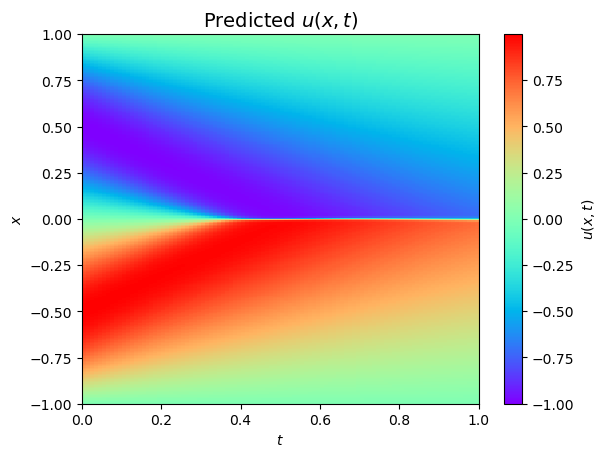

In [55]:
# Show u_pred across domain 
fig, ax = plt.subplots() 

ec = plt.imshow(U_pred.T, interpolation = 'nearest', cmap = 'rainbow', 
                extent = [0.0, 1.0, -1.0, 1.0], 
                origin = 'lower', aspect = 'auto') 

ax.autoscale_view() 
ax.set_xlabel('$t$') 
ax.set_ylabel('$x$') 
cbar = plt.colorbar(ec) 
cbar.set_label('$u(x,t)$') 
plt.title("Predicted $u(x,t)$", fontdict = {'fontsize': 14}) 
plt.show()